<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Generate Data

In [54]:
import pandas as pd

COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_2020_june'

ORIG_FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

TARGET_MONTH_YEAR = pd.datetime(2020,6,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()


In [55]:
if COLAB:
  !pip install -U featuretools
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  !cd dl-projects && ls
else:
  !pip install -U featuretools

Requirement already up-to-date: featuretools in /usr/local/lib/python3.6/dist-packages (0.17.0)
Cloning into 'dl-projects'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 2024 (delta 23), reused 18 (delta 6), pack-reused 1977
Receiving objects: 100% (2024/2024), 79.02 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
01_01_tensor.ipynb	       04_04_auto_ml_4.ipynb	06_stats.ipynb
01_02_correlation.ipynb        04_05_auto_ml_0.ipynb	07_algebra.ipynb
01_03_preprocessing.ipynb      04_05_auto_ml_1.ipynb	08_probability.ipynb
01_04_numpy.ipynb	       04_05_auto_ml_2.ipynb	09_evaluation.ipynb
01_05_parallelization.ipynb    04_06_auto_ml_1.ipynb	50_RL.ipynb
01_06_pandas.ipynb	       04_06_auto_ml_2.ipynb	999_Links.ipynb
01_07_python_0.ipynb	       04_06_auto_ml_3.ipynb	archive
01_07_python_1.ipynb	       04_06_auto_ml_4.ipynb	d01_download.ipynb
01_07_python_2.ipynb	       04_0

In [56]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [57]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import re

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [59]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [60]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [61]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

In [62]:
data = format_tabular(ORIGIN_DATASET)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107847 entries, 0 to 107846
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   DrawNo     107847 non-null  int64         
 1   DrawDate   107847 non-null  datetime64[ns]
 2   PrizeType  107847 non-null  object        
 3   LuckyNo    107847 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


In [64]:
data.tail(24)

,DrawNo,DrawDate,PrizeType,LuckyNo
107823,513520,2020-07-01,SpecialNo9,1303
107824,513620,2020-07-04,1stPrizeNo,2999
107825,513620,2020-07-04,2ndPrizeNo,115
107826,513620,2020-07-04,3rdPrizeNo,5808
107827,513620,2020-07-04,ConsolationNo1,6792
107828,513620,2020-07-04,ConsolationNo10,5049
107829,513620,2020-07-04,ConsolationNo2,9926
107830,513620,2020-07-04,ConsolationNo3,8257
107831,513620,2020-07-04,ConsolationNo4,7643
107832,513620,2020-07-04,ConsolationNo5,204


In [65]:
data['NumberId'] = data['LuckyNo']

In [66]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
107837,513620,2020-07-04,SpecialNo1,8800,8800
107838,513620,2020-07-04,SpecialNo10,2761,2761
107839,513620,2020-07-04,SpecialNo2,793,793
107840,513620,2020-07-04,SpecialNo3,4488,4488
107841,513620,2020-07-04,SpecialNo4,9952,9952
107842,513620,2020-07-04,SpecialNo5,1671,1671
107843,513620,2020-07-04,SpecialNo6,3808,3808
107844,513620,2020-07-04,SpecialNo7,1011,1011
107845,513620,2020-07-04,SpecialNo8,2639,2639
107846,513620,2020-07-04,SpecialNo9,3009,3009


## Data Cleansing

In [67]:
def change_prize_type(x):
  return "Prize"
  # if "Special" in x:
  #   return 'Prize'
  # elif "Consolation" in x:
  #   return 'Prize'
  # else:
  #   return x

def increment_draw_date(x):
  x = x + relativedelta(minutes=1)
  return x

data['PrizeType'] = data['PrizeType'].apply(change_prize_type)

# Add 1 minutes to draw date to avoid overlapping with the cut off date
data['DrawDate'] = data['DrawDate'].apply(increment_draw_date)

In [68]:
data.tail(23)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
107824,513620,2020-07-04 00:01:00,Prize,2999,2999
107825,513620,2020-07-04 00:01:00,Prize,115,115
107826,513620,2020-07-04 00:01:00,Prize,5808,5808
107827,513620,2020-07-04 00:01:00,Prize,6792,6792
107828,513620,2020-07-04 00:01:00,Prize,5049,5049
107829,513620,2020-07-04 00:01:00,Prize,9926,9926
107830,513620,2020-07-04 00:01:00,Prize,8257,8257
107831,513620,2020-07-04 00:01:00,Prize,7643,7643
107832,513620,2020-07-04 00:01:00,Prize,204,204
107833,513620,2020-07-04 00:01:00,Prize,6606,6606


In [69]:
data.describe().round(2)

,DrawNo,LuckyNo,NumberId
count,107847.00,107847.00,107847.00
mean,275206.90,4974.36,4974.36
std,135384.78,2885.66,2885.66
min,40792.00,0.00,0.00
25%,157999.00,2463.00,2463.00
50%,275206.00,4952.00,4952.00
75%,392413.00,7465.00,7465.00
max,513620.00,9999.00,9999.00


Text(0.5, 1.0, 'Draw')

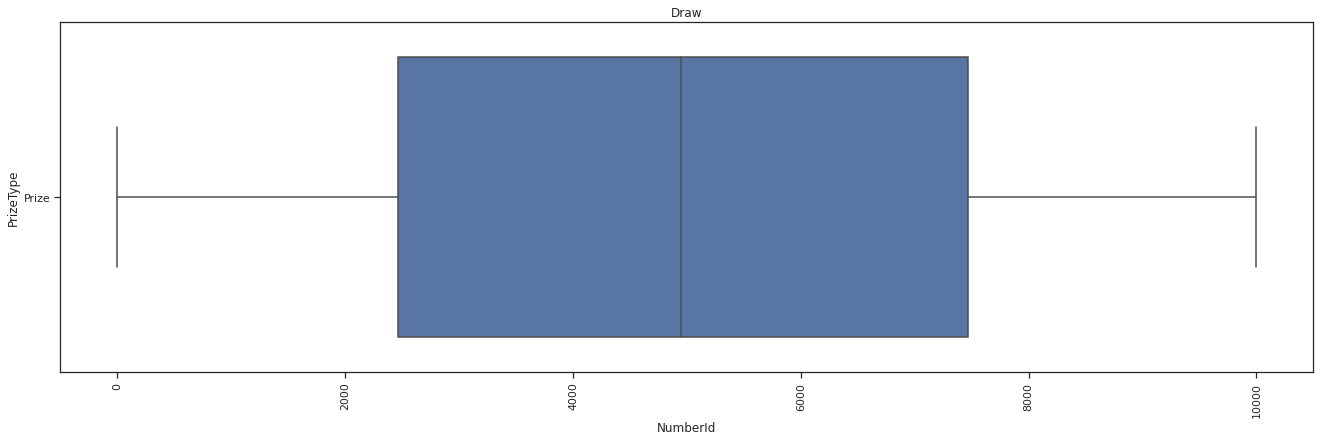

In [70]:
plt.figure(figsize=(20,6))
sns.boxplot(x='NumberId', y='PrizeType',data=data)
plt.xticks(rotation=90)
plt.title('Draw')

# print(data[data['NumberId']==1760])

## Making Labels

In [71]:
data['TotalStrike'] = 1
data.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [72]:
def make_cutoffs(start_date, end_date, threshold=0):
    # Find numbers exist before start date
    number_pool = data[data['DrawDate'] < start_date]['NumberId'].unique()
    tmp = pd.DataFrame({'NumberId': number_pool})
   
    # For numbers in the number pool, find their strike count between the start and end dates
    strike_counts = data[(data['NumberId'].isin(number_pool)) & 
        (data['DrawDate'] >= start_date) & 
        (data['DrawDate']< end_date)
    ].groupby('NumberId')['TotalStrike'].count().reset_index()
    
    number_of_draws = data[
                 (data['DrawDate'] >= start_date) & 
                 (data['DrawDate']< end_date)]['DrawDate'].nunique()
    # display(strike_counts)
    # print(number_of_draws)
    
    # Merge with all the number ids to record all customers who existed before start date
    strike_counts = strike_counts.merge(tmp, on='NumberId', how='right')
    
    # Set the total for any numbers who did not strike in the timeframe equal to 0
    strike_counts['TotalStrike'] = strike_counts['TotalStrike'].fillna(0)
    
    # Label is based on the threshold
    strike_counts['Label'] = (strike_counts['TotalStrike'] > threshold).astype(int)
        
    # The cutoff time is the start date
    strike_counts['time'] = pd.to_datetime(start_date)
    strike_counts = strike_counts[['NumberId', 'time', 'TotalStrike', 'Label']]
    
    #display(strike_counts[strike_counts['Label']==1].nunique())
    #display(strike_counts.sort_values(by='TotalStrike', ascending=False))
   
    return number_of_draws, strike_counts

In [73]:
# For testing purpose
#data = data[data['DrawDate'] < TARGET_MONTH_YEAR]

In [74]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
107837,513620,2020-07-04 00:01:00,Prize,8800,8800,1
107838,513620,2020-07-04 00:01:00,Prize,2761,2761,1
107839,513620,2020-07-04 00:01:00,Prize,793,793,1
107840,513620,2020-07-04 00:01:00,Prize,4488,4488,1
107841,513620,2020-07-04 00:01:00,Prize,9952,9952,1
107842,513620,2020-07-04 00:01:00,Prize,1671,1671,1
107843,513620,2020-07-04 00:01:00,Prize,3808,3808,1
107844,513620,2020-07-04 00:01:00,Prize,1011,1011,1
107845,513620,2020-07-04 00:01:00,Prize,2639,2639,1
107846,513620,2020-07-04 00:01:00,Prize,3009,3009,1


In [75]:
end_month_year = TARGET_MONTH_YEAR +  relativedelta(months=1)
end_month_year

datetime.datetime(2020, 7, 1, 0, 0)

In [76]:
number_of_draws, target_month_year = make_cutoffs(TARGET_MONTH_YEAR, end_month_year)
print(number_of_draws, len(target_month_year))
target_month_year[(target_month_year['Label']==1) & (target_month_year['TotalStrike']==2)].sort_values(by='TotalStrike', ascending=False).head()

6 10000


,NumberId,time,TotalStrike,Label


In [77]:
data[data['NumberId'].isin([203])]

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
27574,160599,1999-12-05 00:01:00,Prize,203,203,1
35044,193101,2001-12-09 00:01:00,Prize,203,203,1
42342,224803,2003-11-16 00:01:00,Prize,203,203,1
52887,270706,2006-07-26 00:01:00,Prize,203,203,1
78724,383013,2013-02-02 00:01:00,Prize,203,203,1
80375,390213,2013-06-26 00:01:00,Prize,203,203,1
82995,401614,2014-02-15 00:01:00,Prize,203,203,1
90708,435116,2016-01-03 00:01:00,Prize,203,203,1
92863,444516,2016-07-13 00:01:00,Prize,203,203,1
96465,460217,2017-05-28 00:01:00,Prize,203,203,1


Text(0.5, 1.0, 'Label Distribution for Target Month Year')

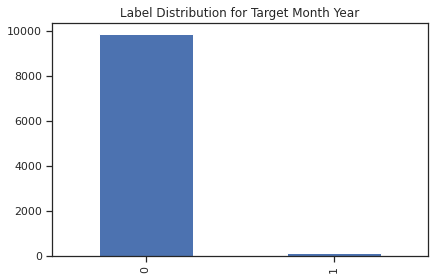

In [78]:
target_month_year['Label'].value_counts().plot.bar()
plt.title('Label Distribution for Target Month Year')

In [79]:
CUT_OFF_YEAR = TARGET_MONTH_YEAR

In [80]:
## Loop through each month starting from CUT_OFF_YEAR

# print(data['DrawDate'].max())
max_year_month = TARGET_MONTH_YEAR  + relativedelta(day=31)
print(f"Max month year: {max_year_month}")

start_year_month = CUT_OFF_YEAR

months_data = []
total_draws = 0
while start_year_month < max_year_month:
    start_date = start_year_month 
    end_date = start_date + relativedelta(months=1)
    start_year_month = start_year_month + relativedelta(months=1)
    print(f"Labels from {start_date} to {end_date}")
    draw_count, month_data = make_cutoffs(start_date, end_date)
    total_draws = total_draws + draw_count
    months_data.append(month_data)

print(f"Total draws: {total_draws}")
print(f"Total draws: {data[(data['DrawDate'] >= CUT_OFF_YEAR) & (data['DrawDate'] <= max_year_month)]['DrawDate'].nunique()}")
print(f"Total months:{len(months_data)}")
print(f"Total records count: {sum([len(l) for l in months_data])}")
print([len(l) for l in months_data])

Max month year: 2020-06-30 00:00:00
Labels from 2020-06-01 00:00:00 to 2020-07-01 00:00:00
Total draws: 6
Total draws: 6
Total months:1
Total records count: 10000
[10000]


In [81]:
labels = pd.concat(months_data)
labels.to_csv(DATASET_PATH/'labels.csv')
labels.describe()

,NumberId,TotalStrike,Label
count,10000.00000,10000.000000,10000.000000
mean,4999.50000,0.013800,0.013800
std,2886.89568,0.116666,0.116666
min,0.00000,0.000000,0.000000
25%,2499.75000,0.000000,0.000000
50%,4999.50000,0.000000,0.000000
75%,7499.25000,0.000000,0.000000
max,9999.00000,1.000000,1.000000


In [82]:
labels.NumberId.nunique(), labels.head(10)

(10000,    NumberId       time  TotalStrike  Label
 0        65 2020-06-01          1.0      1
 1        68 2020-06-01          1.0      1
 2       188 2020-06-01          1.0      1
 3       245 2020-06-01          1.0      1
 4       283 2020-06-01          1.0      1
 5       300 2020-06-01          1.0      1
 6       486 2020-06-01          1.0      1
 7       565 2020-06-01          1.0      1
 8       634 2020-06-01          1.0      1
 9       657 2020-06-01          1.0      1)

In [83]:
labels.tail(10)

,NumberId,time,TotalStrike,Label
9990,3479,2020-06-01,0.0,0
9991,6512,2020-06-01,0.0,0
9992,4996,2020-06-01,0.0,0
9993,3852,2020-06-01,0.0,0
9994,7940,2020-06-01,0.0,0
9995,5407,2020-06-01,0.0,0
9996,7709,2020-06-01,0.0,0
9997,9604,2020-06-01,0.0,0
9998,9659,2020-06-01,0.0,0
9999,5488,2020-06-01,0.0,0


## Automated Feature Engineering

In [84]:
es = ft.EntitySet(id="Lotto Results")

# Add the entire data table as an entity
es.entity_from_dataframe("Results",
                         dataframe=data,
                         index="results_index",
                         time_index = 'DrawDate')

es['Results']

2020-07-05 07:21:28,551 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: Results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
    NumberId (dtype: numeric)
    TotalStrike (dtype: numeric)
  Shape:
    (Rows: 107847, Columns: 7)

In [85]:
es.normalize_entity(new_entity_id="Numbers",
                    base_entity_id="Results",
                    index="NumberId",
                    )

Entityset: Lotto Results
  Entities:
    Results [Rows: 107847, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [86]:
es

Entityset: Lotto Results
  Entities:
    Results [Rows: 107847, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [87]:
es['Numbers'].df.head(24)

,NumberId,first_Results_time
19,19,1992-05-06 00:01:00
1124,1124,1992-05-06 00:01:00
592,592,1992-05-06 00:01:00
5311,5311,1992-05-06 00:01:00
407,407,1992-05-06 00:01:00
1949,1949,1992-05-06 00:01:00
1606,1606,1992-05-06 00:01:00
3775,3775,1992-05-06 00:01:00
6226,6226,1992-05-06 00:01:00
1271,1271,1992-05-06 00:01:00


In [88]:
es['Results'].df.head(24)

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [89]:
len(es['Results'].df)

107847

## Deep Feature Synthesis

In [90]:
# feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
#                                         cutoff_time = labels, verbose = 2,
#                                         cutoff_time_in_index = True,
#                                         chunk_size = len(labels), n_jobs = 1,
#                                         max_depth = 1)
print(ft.__version__)
ft.list_primitives().T

0.17.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
name,median,avg_time_between,percent_true,num_unique,min,trend,mean,time_since_last,any,first,skew,n_most_common,num_true,max,entropy,mode,time_since_first,all,sum,count,last,std,haversine,less_than_equal_to,modulo_numeric,second,day,divide_numeric_scalar,latitude,less_than,greater_than_equal_to,multiply_boolean,not,time_since_previous,diff,greater_than,multiply_numeric,cum_max,subtract_numeric_scalar,time_since,add_numeric_scalar,cum_mean,num_characters,cum_sum,is_weekend,not_equal_scalar,and,equal_scalar,month,age,less_than_equal_to_scalar,minute,modulo_numeric_scalar,divide_by_feature,hour,less_than_scalar,longitude,modulo_by_feature,divide_numeric,greater_than_equal_to_scalar,percentile,absolute,greater_than_scalar,multiply_numeric_scalar,negate,isin,is_null,scalar_subtract_numeric_feature,cum_min,num_words,subtract_numeric,week,add_numeric,cum_count,weekday,not_equal,or,year,equal
type,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,aggregation,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform,transform
dask_compatible,False,False,True,True,True,False,True,False,True,False,False,False,True,True,False,False,False,True,True,True,False,True,False,True,True,True,True,True,False,True,True,True,True,False,False,True,True,False,True,True,True,False,True,False,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,True,False,True,True,False
description,Determines the middlemost number in a list of ...,Computes the average number of seconds between...,Determines the percent of `True` values.,"Determines the number of distinct values, igno...","Calculates the smallest value, ignoring `NaN` ...",Calculates the trend of a variable over time.,Computes the average for a list of values.,Calculates the time elapsed since the last dat...,Determines if any value is 'True' in a list.,Determines the first value in a list.,Computes the extent to which a distribution di...,Determines the `n` most common elements.,Counts the number of `True` values.,"Calculates the highest value, ignoring `NaN` v...",Calculates the entropy for a categorical variable,Determines the most commonly repeated value.,Calculates the time elapsed since the first da...,Calculates if all values are 'True' in a list.,"Calculates the total addition, ignoring `NaN`.","Determines the total number of values, excludi...",Determines the last value in a list.,Computes the dispersion relative to the mean v...,Calculates the approximate haversine distance ...,Determines if values in one list are less than...,Element-wise modulo of two lists.,Determines the seconds value of a datetime.,Determines the day of the month from a datetime.,Divide each element in the list by a scalar.,Returns the first tuple value in a list of Lat...,Determines if values in one list are less than...,Determines if values in one list are greater t...,Element-wise multiplication of two lists of bo...,Negates a boolean value.,Compute the time since the previous entry in a...,Compute the d

In [91]:
# default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
#                            'count', 'sum', 'trend', 'percent_true', 'num_unique', 'time_since_last', 
#                            'time_since_first']
# default_trans_primitives =  ['cum_sum', 'cum_mean', 'month', 'day', 'percentile', 
#                               'time_since', 'time_since_previous', 'cum_min', 'cum_max']

default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
                           'count', 'sum', 'trend', 'percent_true', 'num_unique']
default_trans_primitives =  ['cum_sum', 'cum_mean', 'month', 'day', 'percentile', 
                            'and', 'time_since', 'time_since_previous']

feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
                                        agg_primitives = default_agg_primitives ,
                                        trans_primitives = default_trans_primitives,
                                        cutoff_time = labels, verbose = 1,
                                        cutoff_time_in_index = True,
                                        chunk_size = len(labels), n_jobs = 1,
                                        #chunk_size = 10000, n_jobs = -1,
                                        max_depth = 2)

Built 211 features
Elapsed: 08:55 | Progress: 100%|██████████


In [92]:
len(feature_matrix.columns), feature_matrix.columns

(213, Index(['STD(Results.DrawNo)', 'STD(Results.TotalStrike)',
        'STD(Results.LuckyNo)', 'MAX(Results.DrawNo)',
        'MAX(Results.TotalStrike)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MIN(Results.TotalStrike)',
        'MIN(Results.LuckyNo)', 'MODE(Results.PrizeType)',
        ...
        'PERCENTILE(SUM(Results.LuckyNo))', 'PERCENTILE(LAST(Results.DrawNo))',
        'PERCENTILE(MAX(Results.DrawNo))', 'PERCENTILE(SUM(Results.DrawNo))',
        'PERCENTILE(MEAN(Results.DrawNo))',
        'PERCENTILE(MIN(Results.TotalStrike))',
        'PERCENTILE(MEAN(Results.LuckyNo))', 'PERCENTILE(STD(Results.DrawNo))',
        'TotalStrike', 'Label'],
       dtype='object', length=213))

In [93]:
len(feature_matrix)

10000

In [94]:
feature_matrix.head().T

NumberId,65,68,188,245,283
time,2020-06-01,2020-06-01,2020-06-01,2020-06-01,2020-06-01
STD(Results.DrawNo),136095,142822,120489,132800,119778
STD(Results.TotalStrike),0,0,0,0,0
STD(Results.LuckyNo),0,0,0,0,0
MAX(Results.DrawNo),407114,458117,489619,483018,451916
MAX(Results.TotalStrike),1,1,1,1,1
...,...,...,...,...,...
PERCENTILE(MIN(Results.TotalStrike)),0.50005,0.50005,0.50005,0.50005,0.50005
PERCENTILE(MEAN(Results.LuckyNo)),0.0066,0.0069,0.0189,0.0246,0.0284
PERCENTILE(STD(Results.DrawNo)),0.5263,0.6508,0.2677,0.4672,0.2593


In [95]:
feature_matrix.shape

(10000, 213)

In [96]:
feature_matrix.head(2)

,,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MODE(Results.PrizeType),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.LuckyNo),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.PrizeType),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(TotalStrike)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(SUM(Results.LuckyNo)),CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(MAX(Results.DrawNo)),CUM_MEAN(SUM(Results.DrawNo)),CUM_MEAN(MEAN(Results.DrawNo)),CUM_MEAN(MIN(Results.TotalStrike)),CUM_MEAN(MEAN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(COUNT(Results)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(STD(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),TotalStrike,Label
NumberId,time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
65,2020-06-01,136094.845697,0.0,0.0,407114,1,65,49692,1,65,Prize,260617.75,1,65,-0.342365,0.0,0.0,84270,65,407114,1,Prize,9.701486e+07,8,2084942,8,520,0.0,0.031752,0.0,1,11,29,867974340.0,0.0,31304.828271,0.0,0.0,19.980021,68056.398007,0.0,...,1.0,57547.15158,466128.344403,466128.344403,3.002270e+06,255760.803148,1.0,4961.403856,144684.227637,6,7,0.50005,0.0066,0.155609,0.0066,0.50005,0.2063,0.50005,0.50005,0.50005,0.2063,0.0066,0.256379,0.78515,0.50005,0.50005,0.50005,0.50005,0.18735,0.50005,0.0059,0.0947,0.0947,0.1998,0.3682,0.50005,0.0066,0.5263,1.0,1
68,2020-06-01,142822.272696,0.0,0.0,458117,1,68,76294,1,68,Prize,301722.00,1,68,-0.666601,0.0,0.0,95983,68,458117,1,Prize,1.192752e+08,7,2112054,7,476,0.0,0.032041,0.0,1,8,11,814406340.0,0.0,32847.568468,0.0,0.0,4.207488,71409.041682,0.0,...,1.0,56670.89889,465401.838762,465401.838762,2.971910e+06,260067.304527,1.0,5012.241410,141366.141793,4,15,0.50005,0.0069,0.443811,0.0069,0.50005,0.1242,0.50005,0.50005,0.50005,0.1242,0.0069,0.109377,0.90530,0.50005,0.50005,0.50005,0.50005,0.55895,0.50005,0.0054,0.3098,0.3098,0.2079,0.7382,0.50005,0.0069,0.6508,1.0,1


In [97]:
#feature_matrix[(feature_matrix['NumberId']==0) & (feature_matrix['Label']==1)].head(10)

## Correlations

In [98]:
# Save the original feature matrix
origin_feature_matrix = feature_matrix

feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(10000, 215)

In [99]:
feature_matrix.head(10)

,NumberId,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.LuckyNo),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(TotalStrike)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.DrawNo)),CUM_MEAN(MAX(Results.DrawNo)),CUM_MEAN(SUM(Results.DrawNo)),CUM_MEAN(MEAN(Results.DrawNo)),CUM_MEAN(MIN(Results.TotalStrike)),CUM_MEAN(MEAN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(COUNT(Results)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(STD(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
0,65,2020-06-01,136094.845697,0.0,0.0,407114,1,65,49692,1,65,260617.750000,1,65,-0.342365,0.0,0.0,84270,65,407114,1,9.701486e+07,8,2084942,8,520,0.0,0.031752,0.0,1,11,29,867974340.0,0.0,31304.828271,0.000000,0.0,19.980021,68056.398007,0.0,...,466128.344403,466128.344403,3.002270e+06,255760.803148,1.0,4961.403856,144684.227637,6,7,0.50005,0.0066,0.155609,0.0066,0.50005,0.20630,0.50005,0.50005,0.50005,0.20630,0.0066,0.256379,0.78515,0.50005,0.50005,0.50005,0.50005,0.18735,0.50005,0.00590,0.09470,0.09470,0.1998,0.3682,0.50005,0.0066,0.5263,1.0,1,1,1
1,68,2020-06-01,142822.272696,0.0,0.0,458117,1,68,76294,1,68,301722.000000,1,68,-0.666601,0.0,0.0,95983,68,458117,1,1.192752e+08,7,2112054,7,476,0.0,0.032041,0.0,1,8,11,814406340.0,0.0,32847.568468,0.000000,0.0,4.207488,71409.041682,0.0,...,465401.838762,465401.838762,2.971910e+06,260067.304527,1.0,5012.241410,141366.141793,4,15,0.50005,0.0069,0.443811,0.0069,0.50005,0.12420,0.50005,0.50005,0.50005,0.12420,0.0069,0.109377,0.90530,0.50005,0.50005,0.50005,0.50005,0.55895,0.50005,0.00540,0.30980,0.30980,0.2079,0.7382,0.50005,0.0069,0.6508,1.0,1,1,1
2,188,2020-06-01,120488.735082,0.0,0.0,489619,1,188,103096,1,188,292140.500000,1,188,0.234093,0.0,0.0,103230,188,489619,1,6.526342e+07,12,3505686,12,2256,0.0,0.032489,0.0,1,4,27,760406340.0,0.0,27705.445420,76690.831501,0.0,2.825910,60233.806799,0.0,...,465582.028250,465582.028250,2.979412e+06,264759.320612,1.0,4999.740910,138810.649742,1,26,0.50005,0.0189,0.868408,0.0189,0.50005,0.66060,0.50005,0.50005,0.50005,0.66060,0.0189,0.669469,0.33710,0.50005,0.50005,0.50005,0.50005,0.76460,0.50005,0.02440,0.64520,0.64520,0

In [100]:
corrs = feature_matrix.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

NUM_UNIQUE(Results.DAY(DrawDate))      -0.017350
SKEW(Results.CUM_MEAN(LuckyNo))        -0.015279
MAX(Results.CUM_MEAN(LuckyNo))         -0.014009
PERCENTILE(COUNT(Results))             -0.013147
PERCENTILE(SUM(Results.TotalStrike))   -0.013147
Name: TotalStrike, dtype: float64

In [101]:
corrs['TotalStrike'].dropna().tail(60)

PERCENTILE(TREND(Results.DrawNo, DrawDate))               0.002505
MODE(Results.MONTH(DrawDate))                             0.002847
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    0.003824
DAY(first_Results_time)                                   0.006307
CUM_MEAN(STD(Results.DrawNo))                             0.006621
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))              0.007714
PERCENTILE(LAST(Results.DrawNo))                          0.007730
PERCENTILE(MAX(Results.DrawNo))                           0.007730
TIME_SINCE(first_Results_time)                            0.007965
MAX(Results.TIME_SINCE(DrawDate))                         0.007965
SKEW(Results.CUM_SUM(LuckyNo))                            0.008678
SKEW(Results.CUM_SUM(TotalStrike))                        0.008689
SKEW(Results.DrawNo)                                      0.008690
SKEW(Results.CUM_MEAN(DrawNo))                            0.008692
SKEW(Results.PERCENTILE(DrawNo))                          0.00

In [102]:
feature_matrix['month'] = feature_matrix['time'].dt.month
feature_matrix['year'] = feature_matrix['time'].dt.year

In [103]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 217 entries, NumberId to year
dtypes: datetime64[ns](1), float64(155), int64(59), uint8(2)
memory usage: 16.4 MB


In [104]:
feature_matrix.head()

,NumberId,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.LuckyNo),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(TotalStrike)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(SUM(Results.DrawNo)),CUM_MEAN(MEAN(Results.DrawNo)),CUM_MEAN(MIN(Results.TotalStrike)),CUM_MEAN(MEAN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(COUNT(Results)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(STD(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
0,65,2020-06-01,136094.845697,0.0,0.0,407114,1,65,49692,1,65,260617.750,1,65,-0.342365,0.0,0.0,84270,65,407114,1,9.701486e+07,8,2084942,8,520,0.0,0.031752,0.0,1,11,29,867974340.0,0.0,31304.828271,0.000000,0.0,19.980021,68056.398007,0.0,...,3.002270e+06,255760.803148,1.0,4961.403856,144684.227637,6,7,0.50005,0.0066,0.155609,0.0066,0.50005,0.2063,0.50005,0.50005,0.50005,0.2063,0.0066,0.256379,0.78515,0.50005,0.50005,0.50005,0.50005,0.18735,0.50005,0.0059,0.09470,0.09470,0.1998,0.3682,0.50005,0.0066,0.5263,1.0,1,1,1,6,2020
1,68,2020-06-01,142822.272696,0.0,0.0,458117,1,68,76294,1,68,301722.000,1,68,-0.666601,0.0,0.0,95983,68,458117,1,1.192752e+08,7,2112054,7,476,0.0,0.032041,0.0,1,8,11,814406340.0,0.0,32847.568468,0.000000,0.0,4.207488,71409.041682,0.0,...,2.971910e+06,260067.304527,1.0,5012.241410,141366.141793,4,15,0.50005,0.0069,0.443811,0.0069,0.50005,0.1242,0.50005,0.50005,0.50005,0.1242,0.0069,0.109377,0.90530,0.50005,0.50005,0.50005,0.50005,0.55895,0.50005,0.0054,0.30980,0.30980,0.2079,0.7382,0.50005,0.0069,0.6508,1.0,1,1,1,6,2020
2,188,2020-06-01,120488.735082,0.0,0.0,489619,1,188,103096,1,188,292140.500,1,188,0.234093,0.0,0.0,103230,188,489619,1,6.526342e+07,12,3505686,12,2256,0.0,0.032489,0.0,1,4,27,760406340.0,0.0,27705.445420,76690.831501,0.0,2.825910,60233.806799,0.0,...,2.979412e+06,264759.320612,1.0,4999.740910,138810.649742,1,26,0.50005,0.0189,0.868408,0.0189,0.50005,0.6606,0.50005,0.50005,0.50005,0.6606,0.0189,0.669469,0.33710,0.50005,0.50005,0.50005,0.50005,0.76460,0.50005,0.0244,0.64520,0.64520,0.7230,0.6603,0.50005,0.0189,0.2677,1.0,1,1,1,6,2020
3,245,2020-06-01,132800.326408,0.0,0.0,483018,1,245,45892,1,245,218977.750,1,245,0.791

In [105]:
feature_matrix.tail()

,NumberId,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.LuckyNo),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(TotalStrike)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(SUM(Results.DrawNo)),CUM_MEAN(MEAN(Results.DrawNo)),CUM_MEAN(MIN(Results.TotalStrike)),CUM_MEAN(MEAN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(COUNT(Results)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(STD(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
9995,5407,2020-06-01,33816.271769,0.0,0.0,426715,1,5407,366112,1,5407,405080.666667,1,5407,-1.700598,0.0,0.0,88778,5407,426715,1,5.365440e+07,3,1215242,3,16221,0.0,0.033921,0.0,1,2,19,261359940.0,12787200.0,7771.970235,149649.189774,0.0,1.968982,16897.356249,0.0,...,2.958866e+06,274687.439565,1.0,4998.253301,133269.620963,7,15,0.50005,0.5408,0.999700,0.5408,0.50005,0.00350,0.50005,0.50005,0.50005,0.00350,0.5408,0.005704,0.12510,0.50005,0.50005,0.50005,0.50005,0.9996,0.50005,0.1644,0.14920,0.14920,0.0273,0.9978,0.50005,0.5408,0.0007,0.0,0,1,1,6,2020
9996,7709,2020-06-01,39368.855047,0.0,0.0,501619,1,7709,373212,1,7709,438690.500000,1,7709,0.112795,0.0,0.0,105992,7709,501619,1,3.264686e+07,8,3509524,8,61672,0.0,0.033760,0.0,1,7,15,248659140.0,12700800.0,9055.400179,0.000000,0.0,1.602046,19687.520845,0.0,...,2.958921e+06,274703.844792,1.0,4998.524457,133260.228069,10,12,0.50005,0.7710,0.997798,0.7710,0.50005,0.20630,0.50005,0.50005,0.50005,0.20630,0.7710,0.585410,0.00140,0.50005,0.50005,0.50005,0.50005,0.9997,0.50005,0.6238,0.84770,0.84770,0.7242,0.9998,0.50005,0.7710,0.0011,0.0,0,1,1,6,2020
9997,9604,2020-06-01,60184.617182,0.0,0.0,504619,1,9604,394813,1,9604,463950.333333,1,9604,-1.652326,0.0,0.0,106679,9604,504619,1,9.789120e+07,3,1391851,3,28812,0.0,0.033742,0.0,1,10,1,210383940.0,38275200.0,13838.054740,0.000000,0.0,1.849427,30085.535476,0.0,...,2.958764e+06,274722.773227,1.0,4998.985097,133252.919046,12,15,0.50005,0.9605,0.997598,0.9605,0.50005,0.00350,0.50005,0.50005,0.50005,0.00350,0.9605,0.006805,0.79115,0.50005,0.50005,0.50005,0.50005,0.9998,0.50005,0.2960,0.90800,0.90800,0.0466,1.0000,0.50005,0.9605,0.0056,0.0,0,1,1,6,2020
9998,9659,2020-0

In [106]:
display(feature_matrix.describe())

,NumberId,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.LuckyNo),LAST(Results.DrawNo),LAST(Results.TotalStrike),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.CUM_SUM(TotalStrike)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(SUM(Results.DrawNo)),CUM_MEAN(MEAN(Results.DrawNo)),CUM_MEAN(MIN(Results.TotalStrike)),CUM_MEAN(MEAN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MIN(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(COUNT(Results)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(STD(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
count,10000.00000,10000.000000,10000.0,10000.0,10000.000000,10000.0,10000.00000,10000.000000,10000.0,10000.00000,10000.000000,10000.0,10000.00000,9993.000000,9993.0,9993.0,10000.000000,10000.00000,10000.000000,10000.0,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,9993.0,9993.000000,9993.0,10000.0,10000.000000,10000.000000,1.000000e+04,9.999000e+03,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.0,...,1.000000e+04,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,9.993000e+03,10000.000000,9993.000000,10000.000000,1.000000e+04,10000.000000,9.993000e+03,1.000000e+04,9.993000e+03,10000.000000,10000.000000,9993.000000,10000.000000,1.000000e+04,9.993000e+03,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0
mean,4999.50000,133231.354507,0.0,0.0,465787.374900,1.0,4999.50000,83988.676000,1.0,4999.50000,274757.556905,1.0,4999.50000,0.002538,0.0,0.0,97754.229800,4999.50000,465787.374900,1.0,8.164165e+07,10.766300,2.958580e+06,10.766300,53552.798800,0.0,0.032094,0.0,1.0,6.671400,15.660900,7.992941e+08,7.276472e+04,30640.327319,23490.434995,0.0,10.941889,66611.635485,0.0,0.0,...,2.995455e+06,260777.834556,1.0,4997.240055,141309.367904,6.537700,15.68840,5.000500e-01,0.500050,0.500050,0.500050,5.000500e-01,0.500050,5.000500e-01,5.000500e-01,5.000500e-01,0.500050,0.500050,0.500050,0.500050,5.000500e-01,5.000500e-01,5.000500e-01,5.000500e-01,0.500050,5.000500e-01,0.500050,0.500050,0.500050,0.500050,0.500050,5.

## Save feature matrix

In [107]:
# https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
if COLAB:
    #!ls /content/gdrive/My\ Drive/
    feature_matrix.to_feather(DATASET)
    origin_feature_matrix.to_pickle(DATASET_PATH/f"{FEATURE_DATASET_PREFIX}_orig.pkl")

In [108]:
if COLAB:
  !cd gdrive/"My Drive"/datasets/ && ls -l --block-size=M

total 4849M
-rw------- 1 root root   17M Mar  1 05:47 feature_matrix_2020_feb.ft
-rw------- 1 root root   17M Mar  1 05:39 feature_matrix_2020_jan.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_june.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_june_orig.pkl
-rw------- 1 root root   17M Mar 14 02:03 feature_matrix_2020_mar.ft
-rw------- 1 root root   17M Mar 14 02:03 feature_matrix_2020_mar_orig.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot.ft
-rw------- 1 root root    1M Jul  5 07:21 labels.csv
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_y_test.ft
-rw------- 1 root root    7M Jan 30 04:33 orig_y_train.ft
-rw------- 1 root root    3M Mar 14 13:02 test_X_test.ft
-rw------- 1 root r